# Graph Construction

In [37]:
import os
import torch
import xml.etree.ElementTree as ET
from torch_geometric.data import Data
import glob
import shutil

# Define list of object categories
categories = ['Bicycle', 'Scooter', 'Pedestrian', 'Car', 'MotorBike', 'MotorizedTricycle',
              'Van', 'Bus', 'MultiWheeler', 'Tractor', 'ConstructionVehicle', 'Animal',
              'Truck', 'Tricycle', 'AgricultureVehicle', 'EgoVehicle']

# Create a dictionary for binary encoding of categories
binary_encoding = {category: [int(x) for x in format(i, '04b')] for i, category in enumerate(categories)}

# Define list of actions
dact = {
    'Cutting': 0,
    'LaneChanging': 1,
    'LaneChanging(m)': 2,
    'OverSpeeding': 3,
    'OverTaking': 4,
    'TrafficLight_rulebreak': 5,
    'WrongLane': 6,
    'Wrongturn_rulebreak': 7,
    'Yield': 8,
    'ZigzagMovement': 9
}

# Specify the directory containing the action sequences
source_directory = 'F:\\backup\\server_files\\Datasets\\METEOR_Dataset\\full_graph\\test'
destination_directory = 'F:\\backup\\server_files\\Datasets\\METEOR_Dataset\\full_graph_graphs\\test'  # Change this to your destination directory

# Get a list of all action folders
action_folders = glob.glob(os.path.join(source_directory, '*'))

for action_folder in action_folders:
    # Get the action label based on the action folder name
    action_label = dact.get(os.path.basename(action_folder), -1)  # -1 if action not found in dact

    # Get a list of all sequence folders in the action folder
    sequence_folders = glob.glob(os.path.join(action_folder, 'sequence_*'))

    for seq_folder in sequence_folders:
        node_data = []
        edge_index = []
        edge_attr = []
        num_nodes_per_frame = []

        # Load the XML files in the sequence folder
        for filename in sorted(os.listdir(seq_folder)):
            if filename.endswith('.xml'):
                try:
                    # Load the XML file
                    tree = ET.parse(os.path.join(seq_folder, filename))
                    root = tree.getroot()

                    # Parse the 'size' element to get image width and height
                    size_elem = root.find('size')
                    img_width = float(size_elem.find('width').text)
                    img_height = float(size_elem.find('height').text)

                    frame_nodes = []

                    for i, obj in enumerate(root.findall('object')):
                        # Get the object name and bounding box coordinates
                        name = obj.find('name').text
                        xmin = float(obj.find('bndbox/xmin').text)
                        ymin = float(obj.find('bndbox/ymin').text)
                        xmax = float(obj.find('bndbox/xmax').text)
                        ymax = float(obj.find('bndbox/ymax').text)

                        # Compute w & h
                        w = xmax - xmin
                        h = ymax - ymin

                        # Compute centroid
                        centroid_x = xmin + (w / 2)
                        centroid_y = ymin + (h / 2)

                        # Normalization
                        xmin = xmin / img_width
                        ymin = ymin / img_height
                        norm_w = w / img_width
                        norm_h = h / img_height
                        centroid_x = centroid_x / img_width
                        centroid_y = centroid_y / img_height

                        # Create node features
                        binary_encoded = binary_encoding.get(name, [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
                        node_features = [xmin, ymin, norm_w, norm_h, centroid_x, centroid_y] + binary_encoded
                        frame_nodes.append(node_features)

                    num_nodes_per_frame.append(len(frame_nodes))
                    node_data.extend(frame_nodes)

                except Exception as e:
                    print(f"Error processing {filename} in folder {seq_folder}: {e}")
                    continue

        if not node_data:
            print(f"No valid data objects were processed in folder {seq_folder}")
            continue

        # Create edges and calculate distances and angles
        num_frames = len(num_nodes_per_frame)
        num_nodes_total = sum(num_nodes_per_frame)

        frame_start_idx = [sum(num_nodes_per_frame[:i]) for i in range(num_frames)]

        for i in range(num_frames - 1):
            src_frame_start = frame_start_idx[i]
            dst_frame_start = frame_start_idx[i + 1]

            for src_idx in range(src_frame_start, src_frame_start + num_nodes_per_frame[i]):
                for dst_idx in range(dst_frame_start, dst_frame_start + num_nodes_per_frame[i + 1]):
                    src_centroid_x, src_centroid_y = node_data[src_idx][-2], node_data[src_idx][-1]
                    dst_centroid_x, dst_centroid_y = node_data[dst_idx][-2], node_data[dst_idx][-1]

                    # Calculate distance between centroids
                    distance = ((dst_centroid_x - src_centroid_x) ** 2 + (dst_centroid_y - src_centroid_y) ** 2) ** 0.5

                    # Calculate angle between centroids
                    angle = torch.atan2(torch.tensor(dst_centroid_y) - torch.tensor(src_centroid_y),
                                        torch.tensor(dst_centroid_x) - torch.tensor(src_centroid_x))

                    # Normalize angle between 0 and 1
                    angle = (angle + torch.pi) / (2 * torch.pi)

                    # Append edge_index and edge_attr
                    edge_index.append([src_idx, dst_idx])
                    edge_attr.append([distance, angle])  # Append as a list

        edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
        edge_attr = torch.tensor(edge_attr, dtype=torch.float)  # Convert to tensor

        x = torch.tensor(node_data, dtype=torch.float)
        data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)

        # Add the action label as the 'y' attribute
        data.y = torch.tensor([action_label], dtype=torch.long)

        # Get the name of the sequence folder
        sequence_folder_name = os.path.basename(seq_folder)

        # Create the destination directory for the current action if it doesn't exist
        action_destination_directory = os.path.join(destination_directory, os.path.basename(action_folder))
        os.makedirs(action_destination_directory, exist_ok=True)

        # Save the data object with the name of the sequence folder in its respective sequence folder
        graph_save_path = os.path.join(action_destination_directory, f"{sequence_folder_name}.pt")
        torch.save(data, graph_save_path)

        # Print action label and graph save path
        print(f"Action Label: {action_label}, Graph Save Path: {graph_save_path}")


Action Label: 0, Graph Save Path: F:\backup\server_files\Datasets\METEOR_Dataset\full_graph_graphs\test\Cutting\sequence_01290.pt
Action Label: 0, Graph Save Path: F:\backup\server_files\Datasets\METEOR_Dataset\full_graph_graphs\test\Cutting\sequence_01302.pt
Action Label: 0, Graph Save Path: F:\backup\server_files\Datasets\METEOR_Dataset\full_graph_graphs\test\Cutting\sequence_01317.pt
Action Label: 0, Graph Save Path: F:\backup\server_files\Datasets\METEOR_Dataset\full_graph_graphs\test\Cutting\sequence_01318.pt
Action Label: 0, Graph Save Path: F:\backup\server_files\Datasets\METEOR_Dataset\full_graph_graphs\test\Cutting\sequence_01318_b.pt
Action Label: 0, Graph Save Path: F:\backup\server_files\Datasets\METEOR_Dataset\full_graph_graphs\test\Cutting\sequence_01320.pt
Action Label: 0, Graph Save Path: F:\backup\server_files\Datasets\METEOR_Dataset\full_graph_graphs\test\Cutting\sequence_01327.pt
Action Label: 0, Graph Save Path: F:\backup\server_files\Datasets\METEOR_Dataset\full_gr

Action Label: 0, Graph Save Path: F:\backup\server_files\Datasets\METEOR_Dataset\full_graph_graphs\test\Cutting\sequence_01704.pt
Action Label: 0, Graph Save Path: F:\backup\server_files\Datasets\METEOR_Dataset\full_graph_graphs\test\Cutting\sequence_01705.pt
Action Label: 0, Graph Save Path: F:\backup\server_files\Datasets\METEOR_Dataset\full_graph_graphs\test\Cutting\sequence_01732.pt
Action Label: 0, Graph Save Path: F:\backup\server_files\Datasets\METEOR_Dataset\full_graph_graphs\test\Cutting\sequence_01734.pt
Action Label: 0, Graph Save Path: F:\backup\server_files\Datasets\METEOR_Dataset\full_graph_graphs\test\Cutting\sequence_01759.pt
Action Label: 0, Graph Save Path: F:\backup\server_files\Datasets\METEOR_Dataset\full_graph_graphs\test\Cutting\sequence_01768.pt
Action Label: 1, Graph Save Path: F:\backup\server_files\Datasets\METEOR_Dataset\full_graph_graphs\test\LaneChanging\sequence_01208.pt
Action Label: 1, Graph Save Path: F:\backup\server_files\Datasets\METEOR_Dataset\full

Action Label: 2, Graph Save Path: F:\backup\server_files\Datasets\METEOR_Dataset\full_graph_graphs\test\LaneChanging(m)\sequence_01203.pt
Action Label: 2, Graph Save Path: F:\backup\server_files\Datasets\METEOR_Dataset\full_graph_graphs\test\LaneChanging(m)\sequence_01207.pt
Action Label: 2, Graph Save Path: F:\backup\server_files\Datasets\METEOR_Dataset\full_graph_graphs\test\LaneChanging(m)\sequence_01208.pt
Action Label: 2, Graph Save Path: F:\backup\server_files\Datasets\METEOR_Dataset\full_graph_graphs\test\LaneChanging(m)\sequence_01218.pt
Action Label: 2, Graph Save Path: F:\backup\server_files\Datasets\METEOR_Dataset\full_graph_graphs\test\LaneChanging(m)\sequence_01223.pt
Action Label: 2, Graph Save Path: F:\backup\server_files\Datasets\METEOR_Dataset\full_graph_graphs\test\LaneChanging(m)\sequence_01226.pt
Action Label: 2, Graph Save Path: F:\backup\server_files\Datasets\METEOR_Dataset\full_graph_graphs\test\LaneChanging(m)\sequence_01226_a.pt
Action Label: 2, Graph Save Path

Action Label: 2, Graph Save Path: F:\backup\server_files\Datasets\METEOR_Dataset\full_graph_graphs\test\LaneChanging(m)\sequence_01745.pt
Action Label: 3, Graph Save Path: F:\backup\server_files\Datasets\METEOR_Dataset\full_graph_graphs\test\OverSpeeding\sequence_00669.pt
Action Label: 3, Graph Save Path: F:\backup\server_files\Datasets\METEOR_Dataset\full_graph_graphs\test\OverSpeeding\sequence_01099.pt
Action Label: 4, Graph Save Path: F:\backup\server_files\Datasets\METEOR_Dataset\full_graph_graphs\test\OverTaking\sequence_01007.pt
Action Label: 4, Graph Save Path: F:\backup\server_files\Datasets\METEOR_Dataset\full_graph_graphs\test\OverTaking\sequence_01008.pt
Action Label: 4, Graph Save Path: F:\backup\server_files\Datasets\METEOR_Dataset\full_graph_graphs\test\OverTaking\sequence_01010.pt
Action Label: 4, Graph Save Path: F:\backup\server_files\Datasets\METEOR_Dataset\full_graph_graphs\test\OverTaking\sequence_01011.pt
Action Label: 4, Graph Save Path: F:\backup\server_files\Dat

Action Label: 4, Graph Save Path: F:\backup\server_files\Datasets\METEOR_Dataset\full_graph_graphs\test\OverTaking\sequence_01119.pt
Action Label: 4, Graph Save Path: F:\backup\server_files\Datasets\METEOR_Dataset\full_graph_graphs\test\OverTaking\sequence_01122.pt
Action Label: 4, Graph Save Path: F:\backup\server_files\Datasets\METEOR_Dataset\full_graph_graphs\test\OverTaking\sequence_01124.pt
Action Label: 4, Graph Save Path: F:\backup\server_files\Datasets\METEOR_Dataset\full_graph_graphs\test\OverTaking\sequence_01126.pt
Action Label: 4, Graph Save Path: F:\backup\server_files\Datasets\METEOR_Dataset\full_graph_graphs\test\OverTaking\sequence_01128.pt
Action Label: 4, Graph Save Path: F:\backup\server_files\Datasets\METEOR_Dataset\full_graph_graphs\test\OverTaking\sequence_01128_a.pt
Action Label: 4, Graph Save Path: F:\backup\server_files\Datasets\METEOR_Dataset\full_graph_graphs\test\OverTaking\sequence_01130.pt
Action Label: 4, Graph Save Path: F:\backup\server_files\Datasets\M

Action Label: 4, Graph Save Path: F:\backup\server_files\Datasets\METEOR_Dataset\full_graph_graphs\test\OverTaking\sequence_01240.pt
Action Label: 4, Graph Save Path: F:\backup\server_files\Datasets\METEOR_Dataset\full_graph_graphs\test\OverTaking\sequence_01245.pt
Action Label: 4, Graph Save Path: F:\backup\server_files\Datasets\METEOR_Dataset\full_graph_graphs\test\OverTaking\sequence_01248.pt
Action Label: 4, Graph Save Path: F:\backup\server_files\Datasets\METEOR_Dataset\full_graph_graphs\test\OverTaking\sequence_01248_a.pt
Action Label: 4, Graph Save Path: F:\backup\server_files\Datasets\METEOR_Dataset\full_graph_graphs\test\OverTaking\sequence_01261.pt
Action Label: 4, Graph Save Path: F:\backup\server_files\Datasets\METEOR_Dataset\full_graph_graphs\test\OverTaking\sequence_01264.pt
Action Label: 4, Graph Save Path: F:\backup\server_files\Datasets\METEOR_Dataset\full_graph_graphs\test\OverTaking\sequence_01265.pt
Action Label: 4, Graph Save Path: F:\backup\server_files\Datasets\M

Action Label: 4, Graph Save Path: F:\backup\server_files\Datasets\METEOR_Dataset\full_graph_graphs\test\OverTaking\sequence_01530.pt
Action Label: 4, Graph Save Path: F:\backup\server_files\Datasets\METEOR_Dataset\full_graph_graphs\test\OverTaking\sequence_01537.pt
Action Label: 4, Graph Save Path: F:\backup\server_files\Datasets\METEOR_Dataset\full_graph_graphs\test\OverTaking\sequence_01538.pt
Action Label: 4, Graph Save Path: F:\backup\server_files\Datasets\METEOR_Dataset\full_graph_graphs\test\OverTaking\sequence_01543.pt
Action Label: 4, Graph Save Path: F:\backup\server_files\Datasets\METEOR_Dataset\full_graph_graphs\test\OverTaking\sequence_01549.pt
Action Label: 4, Graph Save Path: F:\backup\server_files\Datasets\METEOR_Dataset\full_graph_graphs\test\OverTaking\sequence_01551.pt
Action Label: 4, Graph Save Path: F:\backup\server_files\Datasets\METEOR_Dataset\full_graph_graphs\test\OverTaking\sequence_01553.pt
Action Label: 4, Graph Save Path: F:\backup\server_files\Datasets\MET

Action Label: 6, Graph Save Path: F:\backup\server_files\Datasets\METEOR_Dataset\full_graph_graphs\test\WrongLane\sequence_01380.pt
Action Label: 6, Graph Save Path: F:\backup\server_files\Datasets\METEOR_Dataset\full_graph_graphs\test\WrongLane\sequence_01380_a.pt
Action Label: 6, Graph Save Path: F:\backup\server_files\Datasets\METEOR_Dataset\full_graph_graphs\test\WrongLane\sequence_01394.pt
Action Label: 6, Graph Save Path: F:\backup\server_files\Datasets\METEOR_Dataset\full_graph_graphs\test\WrongLane\sequence_01396.pt
Action Label: 6, Graph Save Path: F:\backup\server_files\Datasets\METEOR_Dataset\full_graph_graphs\test\WrongLane\sequence_01397.pt
Action Label: 6, Graph Save Path: F:\backup\server_files\Datasets\METEOR_Dataset\full_graph_graphs\test\WrongLane\sequence_01399.pt
Action Label: 6, Graph Save Path: F:\backup\server_files\Datasets\METEOR_Dataset\full_graph_graphs\test\WrongLane\sequence_01399_a.pt
Action Label: 6, Graph Save Path: F:\backup\server_files\Datasets\METEOR

Action Label: 6, Graph Save Path: F:\backup\server_files\Datasets\METEOR_Dataset\full_graph_graphs\test\WrongLane\sequence_01656.pt
Action Label: 6, Graph Save Path: F:\backup\server_files\Datasets\METEOR_Dataset\full_graph_graphs\test\WrongLane\sequence_01684.pt
Action Label: 6, Graph Save Path: F:\backup\server_files\Datasets\METEOR_Dataset\full_graph_graphs\test\WrongLane\sequence_01690.pt
Action Label: 6, Graph Save Path: F:\backup\server_files\Datasets\METEOR_Dataset\full_graph_graphs\test\WrongLane\sequence_01690_a.pt
Action Label: 6, Graph Save Path: F:\backup\server_files\Datasets\METEOR_Dataset\full_graph_graphs\test\WrongLane\sequence_01690_b.pt
Action Label: 6, Graph Save Path: F:\backup\server_files\Datasets\METEOR_Dataset\full_graph_graphs\test\WrongLane\sequence_01710.pt
Action Label: 6, Graph Save Path: F:\backup\server_files\Datasets\METEOR_Dataset\full_graph_graphs\test\WrongLane\sequence_01750.pt
Action Label: 6, Graph Save Path: F:\backup\server_files\Datasets\METEOR

In [5]:
data

DataBatch(x=[812, 10], edge_index=[2, 6569], edge_attr=[6569, 2], y=[4], batch=[812], ptr=[5])

# Graph Loading

In [ ]:
import os
import torch
from torch_geometric.data import Data

# Define the file path of the graph you want to read
file_path = 'F:\\backup\\server_files\\Datasets\\METEOR_Dataset\\small_test_graphs\\train\\Cutting\\sequence_00083.pt'  # Replace with the actual file path

# Check if the file exists
if os.path.exists(file_path):
    # Load the graph using torch.load
    data = torch.load(file_path)



In [10]:
data

Data(x=[243, 10], edge_index=[2, 4202], edge_attr=[4202, 2], y=[1])

# Graph Check code

In [47]:
import os
import torch
from torch_geometric.data import Data

# Define the directory containing the graphs
directory = 'F:\\backup\\server_files\\Datasets\\METEOR_Dataset\\full_graph_graphs\\test\\ZigzagMovement'  # Replace with the actual directory containing the graphs

# Iterate through the files in the directory
for filename in os.listdir(directory):
    if filename.endswith('.pt'):
        # Construct the full file path
        file_path = os.path.join(directory, filename)

        try:
            # Load the graph using torch.load
            data = torch.load(file_path)

            # Check if the 'edge_index' and 'num_nodes' attributes exist in data
            if hasattr(data, 'edge_index') and hasattr(data, 'num_nodes'):
                # Check if the graph has either 0 edge_index or 0 nodes
                if data.edge_index.size(1) == 0 or data.num_nodes == 0:
                    # Delete the graph file
                    os.remove(file_path)
                    print(f"Deleted: {filename}")
        except Exception as e:
            # Handle any exceptions (e.g., invalid file format)
            print(f"Error processing {filename}: {e}")
            # Delete the invalid graph file
            os.remove(file_path)
            print(f"Deleted (Invalid Graph): {filename}")


# Data Loading

In [1]:
import os
import torch
from torch_geometric.data import Dataset, DataLoader
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
class CustomDataset(Dataset):
    def __init__(self, root, transform=None):
        super(CustomDataset, self).__init__(root, transform)
        self.file_paths = []
        
        # Recursively collect file paths for .pt files in subdirectories
        for dirpath, dirnames, filenames in os.walk(root):
            for filename in filenames:
                if filename.endswith('.pt'):
                    self.file_paths.append(os.path.join(dirpath, filename))
 
    def len(self):
        return len(self.file_paths)
 
    def get(self, idx):
        data = torch.load(self.file_paths[idx])
        if self.transform:
            data = self.transform(data)
        return data.to("cpu")
# Define the root directory containing 'roundabout' and 'intersection' folders
train_directory = 'F:\\backup\\server_files\\Datasets\\METEOR_Dataset\\full_graph_graphs\\train'
test_directory = 'F:\\backup\\server_files\\Datasets\\METEOR_Dataset\\full_graph_graphs\\test'
# Create an instance of your custom dataset for both 'roundabout' and 'intersection' data
train_dataset = CustomDataset(train_directory)
test_dataset = CustomDataset(test_directory)
# Define batch size
batch_size = 8
 
# Create a single data loader that loads data from both 'roundabout' and 'intersection' folders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
# # You can now iterate over the train_loader to access your data
# for batch in train_loader:
#     # Your training code here
#     pass

C:\Users\humnabaa\.conda\envs\graph\lib\site-packages\torch_geometric\deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [2]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = "cpu"
print(device)

cpu


# GAT model

In [3]:
# Original two layer GAT implementation
# import torch
# import torch.nn.functional as F
# from torch_geometric.nn import GATConv
# from torch_geometric.data import DataLoader
# from torch.nn import Linear
# from torch.nn import Linear, LogSoftmax
# import torch.nn.functional as F
# from torch_geometric.nn import global_mean_pool

# class GCN(torch.nn.Module):
#     def __init__(self, hidden_channels, num_classes):
#         super(GCN, self).__init__()
#         torch.manual_seed(12345)
#         self.conv1 = GATConv((-1, -1), hidden_channels[0], heads=2, concat=False)  # Keep edge_attr
#         self.conv2 = GATConv((-1, -1), hidden_channels[1], heads=2, concat=False)
#         self.lin = Linear(hidden_channels[1], num_classes)
#         self.log_softmax = LogSoftmax(dim=1)

#     def forward(self, x, edge_index, edge_attr, batch):
#         x = self.conv1(x, edge_index, edge_attr)
#         x = F.relu(x)
#         #x = F.dropout(x, p=0.5, training=self.training)
#         #x = F.dropout(x, p=0.2, training=self.training)
#         x = self.conv2(x, edge_index, edge_attr)
#         x = global_mean_pool(x, batch)
#         x = F.relu(x)
#         x = self.lin(x)
#         x = self.log_softmax(x)
#         return x

# # Define the number of hidden channels and number of classes
# hidden_channels = [32,32]
# num_classes = 10

# model = GCN(hidden_channels=hidden_channels, num_classes=num_classes).to(device)
# #model = GCN(hidden_channels=hidden_channels, num_classes=num_classes)
# print(model)

GCN(
  (conv1): GATConv((-1, -1), 32, heads=2)
  (conv2): GATConv((-1, -1), 32, heads=2)
  (lin): Linear(in_features=32, out_features=10, bias=True)
  (log_softmax): LogSoftmax(dim=1)
)


# GAT Model modifications

## Expt 1 - GAT model (new modifications)

In [4]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATConv
from torch_geometric.data import DataLoader
from torch.nn import Linear
from torch.nn import Linear, LogSoftmax
import torch.nn.functional as F
from torch_geometric.nn import global_mean_pool

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels, num_classes):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GATConv((-1, -1), hidden_channels[0], heads=2, concat=False)  # Keep edge_attr
        self.conv2 = GATConv((-1, -1), hidden_channels[1], heads=2, concat=False)
        self.conv3 = GATConv((-1, -1), hidden_channels[2], heads=2, concat=False)
        self.lin = Linear(hidden_channels[1], num_classes)
        self.log_softmax = LogSoftmax(dim=1)

    def forward(self, x, edge_index, edge_attr, batch):
        x = self.conv1(x, edge_index, edge_attr)
        x = F.relu(x)
        #x = F.dropout(x, p=0.5, training=self.training)
        #x = F.dropout(x, p=0.2, training=self.training)
        x = self.conv2(x, edge_index, edge_attr)
        x = global_mean_pool(x, batch)
        x = F.relu(x)
        x = self.lin(x)
        x = self.log_softmax(x)
        return x

# Define the number of hidden channels and number of classes
hidden_channels = [32,32,32]
num_classes = 10

model = GCN(hidden_channels=hidden_channels, num_classes=num_classes).to(device)
#model = GCN(hidden_channels=hidden_channels, num_classes=num_classes)
print(model)

GCN(
  (conv1): GATConv((-1, -1), 32, heads=2)
  (conv2): GATConv((-1, -1), 32, heads=2)
  (conv3): GATConv((-1, -1), 32, heads=2)
  (lin): Linear(in_features=32, out_features=10, bias=True)
  (log_softmax): LogSoftmax(dim=1)
)


## Expt 2 - GAT model (new modifications)

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATConv
from torch_geometric.data import DataLoader
from torch.nn import Linear
from torch.nn import Linear, LogSoftmax
import torch.nn.functional as F
from torch_geometric.nn import global_mean_pool

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels, num_classes):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GATConv((-1, -1), hidden_channels[0], heads=2, concat=False)  # Keep edge_attr
        self.conv2 = GATConv((-1, -1), hidden_channels[1], heads=2, concat=False)
        self.conv3 = GATConv((-1, -1), hidden_channels[2], heads=2, concat=False)
        self.conv4 = GATConv((-1, -1), hidden_channels[3], heads=2, concat=False)
        self.lin = Linear(hidden_channels[1], num_classes)
        self.log_softmax = LogSoftmax(dim=1)

    def forward(self, x, edge_index, edge_attr, batch):
        x = self.conv1(x, edge_index, edge_attr)
        x = F.relu(x)
        #x = F.dropout(x, p=0.5, training=self.training)
        #x = F.dropout(x, p=0.2, training=self.training)
        x = self.conv2(x, edge_index, edge_attr)
        x = global_mean_pool(x, batch)
        x = F.relu(x)
        x = self.lin(x)
        x = self.log_softmax(x)
        return x

# Define the number of hidden channels and number of classes
hidden_channels = [32,32,32]
num_classes = 10

model = GCN(hidden_channels=hidden_channels, num_classes=num_classes).to(device)
#model = GCN(hidden_channels=hidden_channels, num_classes=num_classes)
print(model)

# Train and test loop

Epoch: 005, Train Accuracy: 0.4087, LR: 0.001000, Test Accuracy: 0.4481, Train mAP: 0.1630, Test mAP: 0.1945
Epoch: 010, Train Accuracy: 0.5066, LR: 0.001000, Test Accuracy: 0.5056, Train mAP: 0.1990, Test mAP: 0.2208
Epoch: 015, Train Accuracy: 0.5387, LR: 0.001000, Test Accuracy: 0.5093, Train mAP: 0.2204, Test mAP: 0.2398
Epoch: 020, Train Accuracy: 0.5437, LR: 0.001000, Test Accuracy: 0.5481, Train mAP: 0.2429, Test mAP: 0.2650
Epoch: 025, Train Accuracy: 0.5564, LR: 0.001000, Test Accuracy: 0.5444, Train mAP: 0.2652, Test mAP: 0.2727
Epoch: 030, Train Accuracy: 0.5637, LR: 0.001000, Test Accuracy: 0.5574, Train mAP: 0.2780, Test mAP: 0.2950
Epoch: 035, Train Accuracy: 0.5705, LR: 0.001000, Test Accuracy: 0.5500, Train mAP: 0.3203, Test mAP: 0.3428
Epoch: 040, Train Accuracy: 0.5700, LR: 0.001000, Test Accuracy: 0.5519, Train mAP: 0.3166, Test mAP: 0.3469
Epoch: 045, Train Accuracy: 0.5773, LR: 0.001000, Test Accuracy: 0.5481, Train mAP: 0.3108, Test mAP: 0.2995
Epoch: 050, Train A

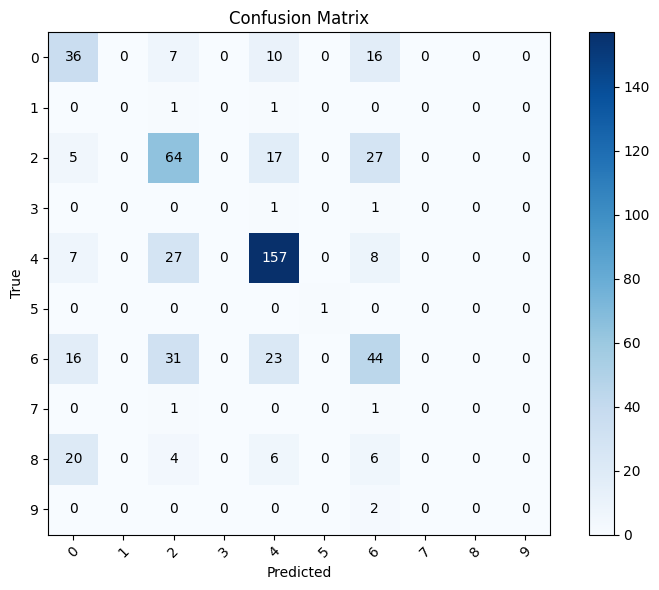

In [5]:
#Train and test loop for Graph Attention Networks (GAT)
import torch.optim as optim
import torch.nn.functional as F
from sklearn.metrics import average_precision_score
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
 
# ... (Your existing code up to this point)
epoch = 200
optimizer = optim.Adam(model.parameters(), lr=0.0005)
criterion = torch.nn.NLLLoss()
reduce_lr_epochs = 50  # Define the number of epochs after which to reduce LR
gamma = 0.5  # Define the LR reduction factor
 
train_acc_history = []
test_acc_history = []
train_mAP_history = []
test_mAP_history = []
lr_history = []  # List to store LR changes
 
def adjust_learning_rate(optimizer, epoch):
    """Sets the learning rate to the initial LR decayed by gamma every reduce_lr_epochs epochs."""
    lr = 0.001 * (gamma ** (epoch // reduce_lr_epochs))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
        
def train_and_test(epoch):
    model.train()
    correct = 0
    total = 0
    y_true_train = []
    y_scores_train = []
 
    for data in train_loader:
        data = data.to(device)
        out = model(data.x, data.edge_index, data.edge_attr, data.batch)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
 
        # Calculate training accuracy
        with torch.no_grad():
            pred = out.argmax(dim=1)
            correct += int((pred == data.y).sum())
            total += data.y.size(0)
 
            pred_probs = F.softmax(out, dim=1)
            y_scores_train.extend(pred_probs.cpu().tolist())
            y_true_train.extend(data.y.cpu().tolist())
 
    train_accuracy = correct / total
    mAPs_train = []
    num_classes = len(y_scores_train[0])
    for class_idx in range(num_classes):
        y_true_class = [int(label == class_idx) for label in y_true_train]
        y_scores_class = [scores[class_idx] for scores in y_scores_train]
        mAP_class = average_precision_score(y_true_class, y_scores_class)
        mAPs_train.append(mAP_class)
 
    mean_mAP_train = sum(mAPs_train) / len(mAPs_train)
 
    if epoch % 5 == 0:  # Perform testing every 5 epochs
        train_acc_history.append(train_accuracy)
        train_mAP_history.append(mean_mAP_train)
 
        # Testing
        model.eval()
        correct_test = 0
        total_test = 0
        y_true_test = []
        y_scores_test = []
 
        for data in test_loader:
            data = data.to(device)
            with torch.no_grad():
                out_test = model(data.x, data.edge_index, data.edge_attr, data.batch)
                pred_test = out_test.argmax(dim=1)
                correct_test += int((pred_test == data.y).sum())
                total_test += data.y.size(0)
 
                pred_probs_test = F.softmax(out_test, dim=1)
                y_scores_test.extend(pred_probs_test.cpu().tolist())
                y_true_test.extend(data.y.cpu().tolist())
 
        test_accuracy = correct_test / total_test
        mAPs_test = []
        num_classes_test = len(y_scores_test[0])
        for class_idx in range(num_classes_test):
            y_true_class_test = [int(label == class_idx) for label in y_true_test]
            y_scores_class_test = [scores[class_idx] for scores in y_scores_test]
            mAP_class_test = average_precision_score(y_true_class_test, y_scores_class_test)
            mAPs_test.append(mAP_class_test)
 
        mean_mAP_test = sum(mAPs_test) / len(mAPs_test)
        test_acc_history.append(test_accuracy)
        test_mAP_history.append(mean_mAP_test)
 
        current_lr = optimizer.param_groups[0]['lr']
        print(f'Epoch: {epoch:03d}, Train Accuracy: {train_accuracy:.4f}, LR: {current_lr:.6f}, Test Accuracy: {test_accuracy:.4f}, Train mAP: {mean_mAP_train:.4f}, Test mAP: {mean_mAP_test:.4f}')
 
    # Save the LR change
    if epoch % reduce_lr_epochs == 0:
        lr_history.append(current_lr)
        print(f'Learning rate changed to: {current_lr:.6f}')

# Train and test loop
for epoch in range(1, epoch):
    adjust_learning_rate(optimizer, epoch)  # Adjust learning rate
    train_and_test(epoch)
    
# Print LR history
print("Learning Rate History:")
for epoch, lr in enumerate(lr_history):
    print(f'Epoch {epoch * reduce_lr_epochs}: {lr:.6f}')

# Compute and plot the confusion matrix
y_true = []  # True labels
y_pred = []  # Predicted labels
 
# Set the model to evaluation mode
model.eval()
 
for data in test_loader:
    data = data.to(device)
    with torch.no_grad():
        out_test = model(data.x, data.edge_index, data.edge_attr, data.batch)
        pred_test = out_test.argmax(dim=1).cpu().numpy()
        y_true.extend(data.y.cpu().numpy())
        y_pred.extend(pred_test)
        
# Compute confusion matrix
confusion = confusion_matrix(y_true, y_pred)
 
# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(confusion, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
 
# Replace 'Class 0', 'Class 1', 'Class 2', etc. with your actual class labels
classes = ['0', '1','2','3','4','5','6','7','8','9']  # Replace with your class labels
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
 
# Display values inside the matrix
for i in range(len(classes)):
    for j in range(len(classes)):
        plt.text(j, i, str(confusion[i][j]), ha='center', va='center', color='white' if confusion[i][j] > confusion.max() / 2 else 'black')

plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

In [7]:
max(test_acc_history)

0.5740740740740741

In [8]:
max(test_mAP_history)

0.3650600714533991

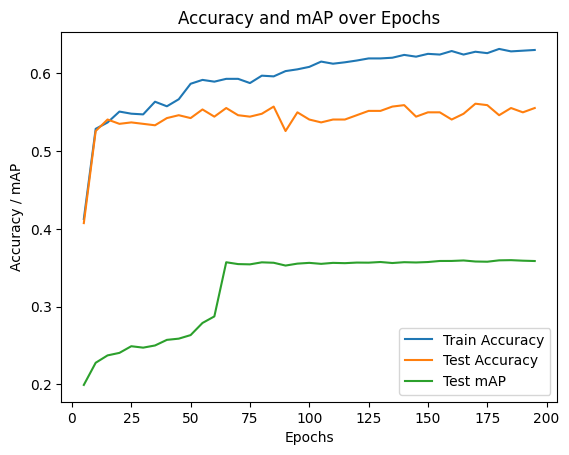

In [5]:
plt.plot(range(5, 200, 5), train_acc_history, label='Train Accuracy')
plt.plot(range(5, 200, 5), test_acc_history, label='Test Accuracy')
plt.plot(range(5, 200, 5), test_mAP_history, label='Test mAP')
plt.xlabel('Epochs')
plt.ylabel('Accuracy / mAP')
plt.title('Accuracy and mAP over Epochs')
plt.legend()
plt.show()

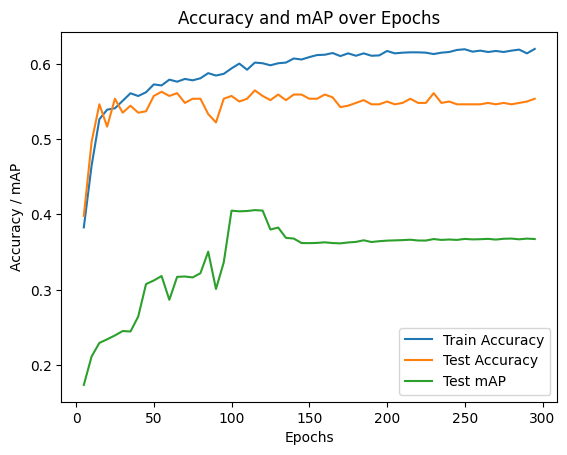

In [8]:
plt.plot(range(5, 300, 5), train_acc_history, label='Train Accuracy')
plt.plot(range(5, 300, 5), test_acc_history, label='Test Accuracy')
plt.plot(range(5, 300, 5), test_mAP_history, label='Test mAP')
plt.xlabel('Epochs')
plt.ylabel('Accuracy / mAP')
plt.title('Accuracy and mAP over Epochs')
plt.legend()
plt.show()

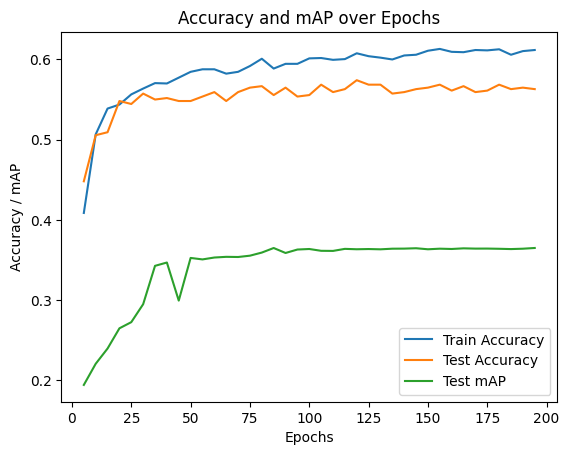

In [9]:
plt.plot(range(5, 200, 5), train_acc_history, label='Train Accuracy')
plt.plot(range(5, 200, 5), test_acc_history, label='Test Accuracy')
plt.plot(range(5, 200, 5), test_mAP_history, label='Test mAP')
plt.xlabel('Epochs')
plt.ylabel('Accuracy / mAP')
plt.title('Accuracy and mAP over Epochs')
plt.legend()
plt.show()